# ANN for Fashion MNIST with PyTorch

In [1]:
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import nn
from torch import optim
import torch
import numpy as np
import matplotlib.pyplot as plt
import pycuda.driver as cuda

CUDA Device

In [2]:
torch.cuda.current_device()

0

Using CUDA if it is avaliable; otherwise it is CPU

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
mean, std = (0.5,), (0.5,)

# Create a transform and normalise data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean, std)
                              ])

Loading Training and Test data into trainloader

In [5]:
# Download FMNIST dataset and load training data
trainset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download FMNIST dataset and load test data
testset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Defining a Class for the Neural Network: <br>
(1) 784 Nodes/Activation: ReLu <br>
(2) 128 Nodes/Activation: ReLu <br>
(3) 64 Nodes <br>
(4) 10 Nodes <br><br>
<b>NOTE: We dont use LogSoftMax because it is included in the PyTorch CrossEntropyLoss with NLLLoss (Negative Log Likelihood Loss) </b>

In [6]:
class FMNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,10)
    
    def forward(self, x):
        x = x.view(x.shape[0], -1)
    
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
    
        return x

In [7]:
model = FMNIST() #Creating Object of the Neural Network Class

Moving the model to GPU memory from CPU

In [8]:
model.to(device)

FMNIST(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

Optimizer is Stochastic Gradient Descent with Learning rate of 0.01

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

num_epochs = 8

for i in range(num_epochs):
    cum_loss = 0

    for images, labels in trainloader:
        images = images.to(device) #We move the Image & Label to GPU Memory
        labels = labels.to(device)
        
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        cum_loss += loss.item()
     
    print(f"Training loss: {cum_loss/len(trainloader)}")

Training loss: 1.0341007123306107
Training loss: 0.5562823609883851
Training loss: 0.4879348192896162
Training loss: 0.45507744698127955
Training loss: 0.43245339622375556
Training loss: 0.41522668562591203
Training loss: 0.40081274212359874
Training loss: 0.3885543545457854


In [10]:
images, labels = next(iter(testloader))

test_image_id = 3 #Random number selected to check
img = images[test_image_id].view(1, 784) 

model.to("cpu") #We move the Model back to the CPU
with torch.no_grad():
    logps = model(img)

The specific labels

<BarContainer object of 10 artists>

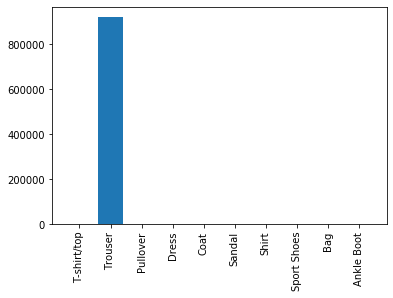

In [11]:
ps = torch.exp(logps)
nps = ps.numpy()[0]
FMNIST_labels = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sport Shoes','Bag','Ankle Boot']
plt.xticks(np.arange(10),labels=FMNIST_labels,rotation='vertical')
plt.bar(np.arange(10), nps)

Showing the a Random Test Image that we just tested on

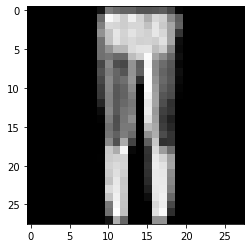

In [12]:
img = img.view(28,-1)
plt.imshow(img,cmap='gray')

Getting Accuracy Value on our Test Data

In [13]:
with torch.no_grad():
    num_correct = 0
    total = 0

    #set_trace()
    for images, labels in testloader:
        
        logps = model(images)
        output = torch.exp(logps)
        
        pred = torch.argmax(output, 1)
        total += labels.size(0)
        num_correct += (pred == labels).sum().item()

    print(f'Accuracy of the model on the 10000 test images: {num_correct * 100 / total}% ')

Accuracy of the model on the 10000 test images: 84.22% 


In [14]:
torch.save(model.state_dict(), './net.pth')
torch.save(model, './FashionMNISTmodel.pth')
model.load_state_dict(torch.load('./net.pth'))

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type FMNIST. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


<All keys matched successfully>